# **Pharmaceutical Sales prediction across multiple stores**

**Forecasting Sales is a essential use of Machine Learning(ML).Sales forecasts can be used to identify benchmarks and determine incremental impacts of new initiatives, plan resources in response to expected demand and project future budgets.**

## **Table of contents**
     1. Exploring the data and Data Pre-processing
     2. Building models with sklearn pipelines
     3. Choose a loss function
     4. Post Prediction analysis
     5. Serialize models

 ## **1. Data Preprocessing**

  1.1 Importing Libraries

In [ ]:
!pip install category_encoders
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn import metrics
import numpy as np 
import matplotlib.pyplot as plt
import category_encoders as ce
%matplotlib inline
import pickle

In [318]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [319]:
train_data=pd.read_csv(r'/content/drive/My Drive/Output.csv')

In [320]:
train_data.head()

,Weekdays,Weeks,Months,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Store-1,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,23,6,867,3,6/3/2015,5608,469,1,1,0.0,0,867,d,c,21810.0,9.0,2012.0,0,NaN,NaN,"Jan,Apr,Jul,Oct"
1,1,23,6,868,3,6/3/2015,13500,816,1,1,0.0,0,868,d,c,1360.0,8.0,2005.0,1,10.0,2014.0,"Jan,Apr,Jul,Oct"
2,1,23,6,869,3,6/3/2015,7007,932,1,1,0.0,0,869,c,a,230.0,10.0,2001.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,1,23,6,870,3,6/3/2015,7911,971,1,1,0.0,0,870,a,a,780.0,4.0,2009.0,0,NaN,NaN,"Jan,Apr,Jul,Oct"
4,1,23,6,871,3,6/3/2015,9198,678,1,1,0.0,0,871,d,c,10620.0,NaN,NaN,0,NaN,NaN,"Jan,Apr,Jul,Oct"


**1.2 Cleansing the Data**

   1.2.1 Handling Null values

In [321]:
#Checking the no. of NaN values
train_data.isna().sum()

Weekdays                          0
Weeks                             0
Months                            0
Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                  31050
SchoolHoliday                     0
Store-1                           0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                     0
dtype: int64

1) CompetitionDistance:

* Before deciding how to treat this,we know there are infinite ways of filling missing values.
* The most common and simplistic approach is to fill it with either the mean or the median of this variable.
* Let's quickly have a look at those metrics.

In [322]:
train_data[pd.isnull(train_data.CompetitionDistance)].head()

,Weekdays,Weeks,Months,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Store-1,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
12,1,23,6,879,3,6/3/2015,5155,436,1,1,0.0,1,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"
411,1,47,11,291,3,11/19/2014,0,0,0,0,NaN,0,291,d,a,NaN,NaN,NaN,0,NaN,NaN,"Jan,Apr,Jul,Oct"
676,1,23,6,291,2,6/2/2015,9897,973,1,1,0.0,0,291,d,a,NaN,NaN,NaN,0,NaN,NaN,"Jan,Apr,Jul,Oct"
1007,1,23,6,622,2,6/2/2015,5389,470,1,1,0.0,0,622,a,c,NaN,NaN,NaN,0,NaN,NaN,"Jan,Apr,Jul,Oct"
1663,1,52,12,291,4,12/25/2014,0,0,0,0,NaN,1,291,d,a,NaN,NaN,NaN,0,NaN,NaN,"Jan,Apr,Jul,Oct"


In [323]:
df_store_check_distribution=train_data.drop(train_data[pd.isnull(train_data.CompetitionDistance)].index)
df_store_check_distribution.head()

,Weekdays,Weeks,Months,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Store-1,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,23,6,867,3,6/3/2015,5608,469,1,1,0.0,0,867,d,c,21810.0,9.0,2012.0,0,NaN,NaN,"Jan,Apr,Jul,Oct"
1,1,23,6,868,3,6/3/2015,13500,816,1,1,0.0,0,868,d,c,1360.0,8.0,2005.0,1,10.0,2014.0,"Jan,Apr,Jul,Oct"
2,1,23,6,869,3,6/3/2015,7007,932,1,1,0.0,0,869,c,a,230.0,10.0,2001.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,1,23,6,870,3,6/3/2015,7911,971,1,1,0.0,0,870,a,a,780.0,4.0,2009.0,0,NaN,NaN,"Jan,Apr,Jul,Oct"
4,1,23,6,871,3,6/3/2015,9198,678,1,1,0.0,0,871,d,c,10620.0,NaN,NaN,0,NaN,NaN,"Jan,Apr,Jul,Oct"


{'Mean': 5430.085652302903, 'Median': 2330.0, 'Standard Dev': 7715.31989799512}

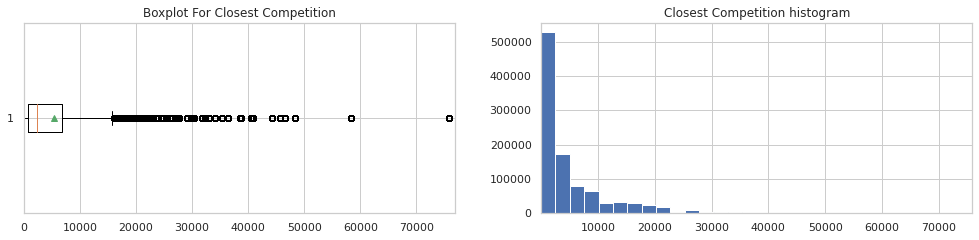

In [324]:
df_store_check_distribution=train_data.drop(train_data[pd.isnull(train_data.CompetitionDistance)].index)
fig, axes = plt.subplots(1, 2, figsize=(17,3.5))
axes[0].boxplot(df_store_check_distribution.CompetitionDistance, showmeans=True,vert=False,)
axes[0].set_xlim(0,max(df_store_check_distribution.CompetitionDistance+1000))
axes[0].set_title('Boxplot For Closest Competition')
axes[1].hist(df_store_check_distribution.CompetitionDistance, cumulative=False, bins=30)
axes[1].set_title("Closest Competition histogram")
axes[1].set_xlim((min(df_store_check_distribution.CompetitionDistance), max(df_store_check_distribution.CompetitionDistance)))
{"Mean":np.nanmean(train_data.CompetitionDistance),"Median":np.nanmedian(train_data.CompetitionDistance),"Standard Dev":np.nanstd(train_data.CompetitionDistance)}#That's what i thought, very different values, let's see why 

We see a highly right skewed distribution for this variable with a significant difference between the mean and the median. This being caused by the amount of disperness in the data with a standard deviation of 7659, higher than the mean and the median.

**What do we do then?**

It is realistically better to input the median value to the Nan stores then the mean since the mean is biased by those outliers.

In [325]:
train_data['CompetitionDistance'].fillna(train_data['CompetitionDistance'].median(), inplace = True)

2) CompetitionOpenSinceMonth and CompetitionOpenSinceYear?

* Since we have no information whatsoever on those missing values and no accurate way of filling those values.
* A creative way could be to apply a multilabel classification algorithm and train on the non Nan fields and then predict what could be most probably the month and year for those fields. But this approach is computationally too long.
* So for this purpose those fields are going to be assigned to 0 .

In [326]:
train_data.CompetitionOpenSinceMonth.fillna(0, inplace = True)
train_data.CompetitionOpenSinceYear.fillna(0,inplace=True)

3) Promo2SinceWeek, Promo2SinceYear and PromoInterval ?



* This case is pretty straighforward, all the missing values comes from fields where Promo2=0 which means there are no continuous promotional activities for those stores.
* Having no promotion means those fields have to be 0 as well since they are linked to Promo2.

In [327]:
train_data.Promo2SinceWeek.fillna(0,inplace=True)
train_data.Promo2SinceYear.fillna(0,inplace=True)
train_data.PromoInterval.fillna(0,inplace=True)


4) StateHoliday

In [328]:
train_data.StateHoliday.fillna(0,inplace=True)

In [329]:
train_data.count(0)/train_data.shape[0] * 100

Weekdays                     100.0
Weeks                        100.0
Months                       100.0
Store                        100.0
DayOfWeek                    100.0
Date                         100.0
Sales                        100.0
Customers                    100.0
Open                         100.0
Promo                        100.0
StateHoliday                 100.0
SchoolHoliday                100.0
Store-1                      100.0
StoreType                    100.0
Assortment                   100.0
CompetitionDistance          100.0
CompetitionOpenSinceMonth    100.0
CompetitionOpenSinceYear     100.0
Promo2                       100.0
Promo2SinceWeek              100.0
Promo2SinceYear              100.0
PromoInterval                100.0
dtype: float64

**Now all the null values are imputed**

1.2.2 Handling Outliers

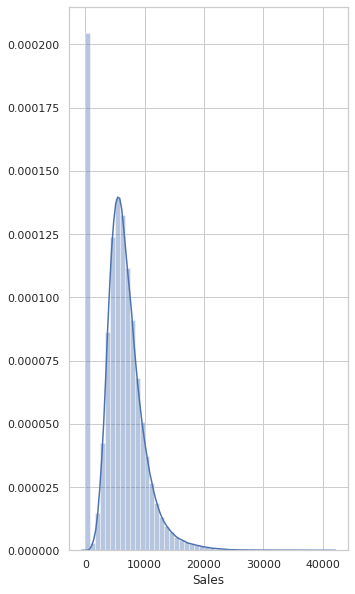

In [330]:
#Find the range of data
plt.figure(figsize=(5,10))
sns.set(style="whitegrid")
sns.distplot(train_data["Sales"])

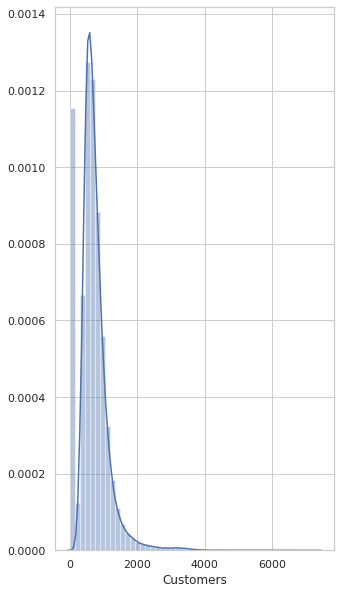

In [331]:
#Find the range of the data
plt.figure(figsize=(5,10))
sns.set(style="whitegrid")
sns.distplot(train_data["Customers"])

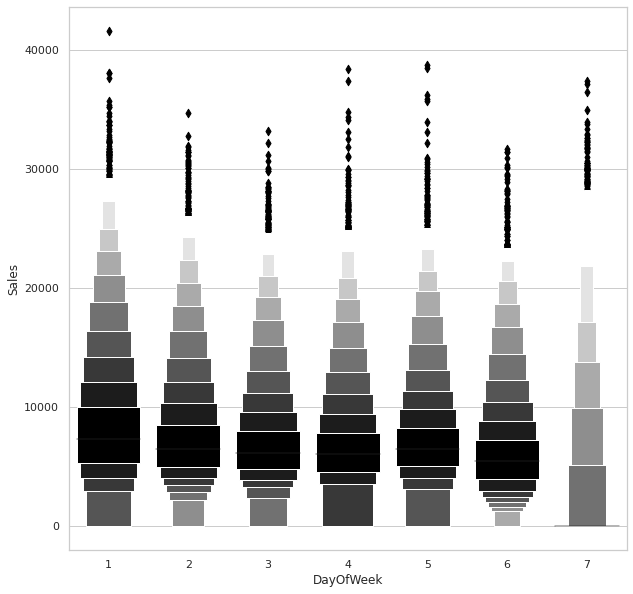

In [332]:
plt.figure(figsize=(10,10))
sns.set(style="whitegrid")
sns.boxenplot(data=train_data,scale="linear",x="DayOfWeek",y="Sales",color="Black")

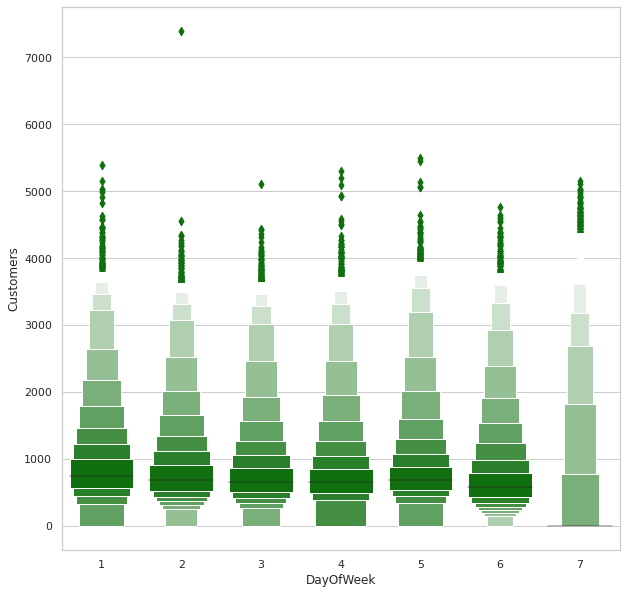

In [333]:
plt.figure(figsize=(10,10))
sns.set(style="whitegrid")
sns.boxenplot(y="Customers", x="DayOfWeek",data=train_data, scale="linear",color="Green")

This data, contains many outliers, but these might have been caused to the surge of customers during a festival or Holiday, or due to an effective promo. 
Below we are handle the outliers

In [334]:
#Treating the outliers 
  # a function for replacing outliers with the median, used when there's too many outliers in a feature
def replace_outlier_with_median(dataFrame, feature):
    Q1 = dataFrame[feature].quantile(0.25)
    Q3 = dataFrame[feature].quantile(0.75)
    median = dataFrame[feature].quantile(0.50)

    IQR = Q3 - Q1

    upper_whisker = Q3 + (1.5 * IQR)
    lower_whisker = Q1 - (1.5 * IQR)

    dataFrame[feature] = np.where(dataFrame[feature] > upper_whisker, median, dataFrame[feature])
    dataFrame[feature] = np.where(dataFrame[feature] < lower_whisker, median, dataFrame[feature])

In [335]:
replace_outlier_with_median(train_data, 'Sales')

In [336]:
replace_outlier_with_median(train_data, 'Customers')

1.3 **Feature Engeneering**

Generating new features from already existing features. 



In [337]:
train_data.head()

,Weekdays,Weeks,Months,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Store-1,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,23,6,867,3,6/3/2015,5608.0,469.0,1,1,0.0,0,867,d,c,21810.0,9.0,2012.0,0,0.0,0.0,"Jan,Apr,Jul,Oct"
1,1,23,6,868,3,6/3/2015,13500.0,816.0,1,1,0.0,0,868,d,c,1360.0,8.0,2005.0,1,10.0,2014.0,"Jan,Apr,Jul,Oct"
2,1,23,6,869,3,6/3/2015,7007.0,932.0,1,1,0.0,0,869,c,a,230.0,10.0,2001.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,1,23,6,870,3,6/3/2015,7911.0,971.0,1,1,0.0,0,870,a,a,780.0,4.0,2009.0,0,0.0,0.0,"Jan,Apr,Jul,Oct"
4,1,23,6,871,3,6/3/2015,9198.0,678.0,1,1,0.0,0,871,d,c,10620.0,0.0,0.0,0,0.0,0.0,"Jan,Apr,Jul,Oct"


In [338]:
#Adding salespercustomer column
train_data['SalesperCustomer']=train_data['Sales']/train_data['Customers']

In [339]:
train_data.head()

,Weekdays,Weeks,Months,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Store-1,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,SalesperCustomer
0,1,23,6,867,3,6/3/2015,5608.0,469.0,1,1,0.0,0,867,d,c,21810.0,9.0,2012.0,0,0.0,0.0,"Jan,Apr,Jul,Oct",11.957356
1,1,23,6,868,3,6/3/2015,13500.0,816.0,1,1,0.0,0,868,d,c,1360.0,8.0,2005.0,1,10.0,2014.0,"Jan,Apr,Jul,Oct",16.544118
2,1,23,6,869,3,6/3/2015,7007.0,932.0,1,1,0.0,0,869,c,a,230.0,10.0,2001.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",7.518240
3,1,23,6,870,3,6/3/2015,7911.0,971.0,1,1,0.0,0,870,a,a,780.0,4.0,2009.0,0,0.0,0.0,"Jan,Apr,Jul,Oct",8.147271
4,1,23,6,871,3,6/3/2015,9198.0,678.0,1,1,0.0,0,871,d,c,10620.0,0.0,0.0,0,0.0,0.0,"Jan,Apr,Jul,Oct",13.566372


In [340]:
train_data['Date'] = pd.to_datetime(train_data['Date'])

In [341]:
train_data['Year']=train_data.Date.dt.year

In [342]:
del train_data["Date"]
train_data.head()

,Weekdays,Weeks,Months,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Store-1,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,SalesperCustomer,Year
0,1,23,6,867,3,5608.0,469.0,1,1,0.0,0,867,d,c,21810.0,9.0,2012.0,0,0.0,0.0,"Jan,Apr,Jul,Oct",11.957356,2015
1,1,23,6,868,3,13500.0,816.0,1,1,0.0,0,868,d,c,1360.0,8.0,2005.0,1,10.0,2014.0,"Jan,Apr,Jul,Oct",16.544118,2015
2,1,23,6,869,3,7007.0,932.0,1,1,0.0,0,869,c,a,230.0,10.0,2001.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",7.518240,2015
3,1,23,6,870,3,7911.0,971.0,1,1,0.0,0,870,a,a,780.0,4.0,2009.0,0,0.0,0.0,"Jan,Apr,Jul,Oct",8.147271,2015
4,1,23,6,871,3,9198.0,678.0,1,1,0.0,0,871,d,c,10620.0,0.0,0.0,0,0.0,0.0,"Jan,Apr,Jul,Oct",13.566372,2015


In [343]:
#correlation Analysis

In [344]:
df_correlation=train_data[['Store', 'DayOfWeek', 'Sales', 'Customers', 'Promo',
        'SchoolHoliday',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'SalesperCustomer', 'Months', 'Year',
       'StateHoliday', 'Assortment', 'StoreType',
       'PromoInterval']]


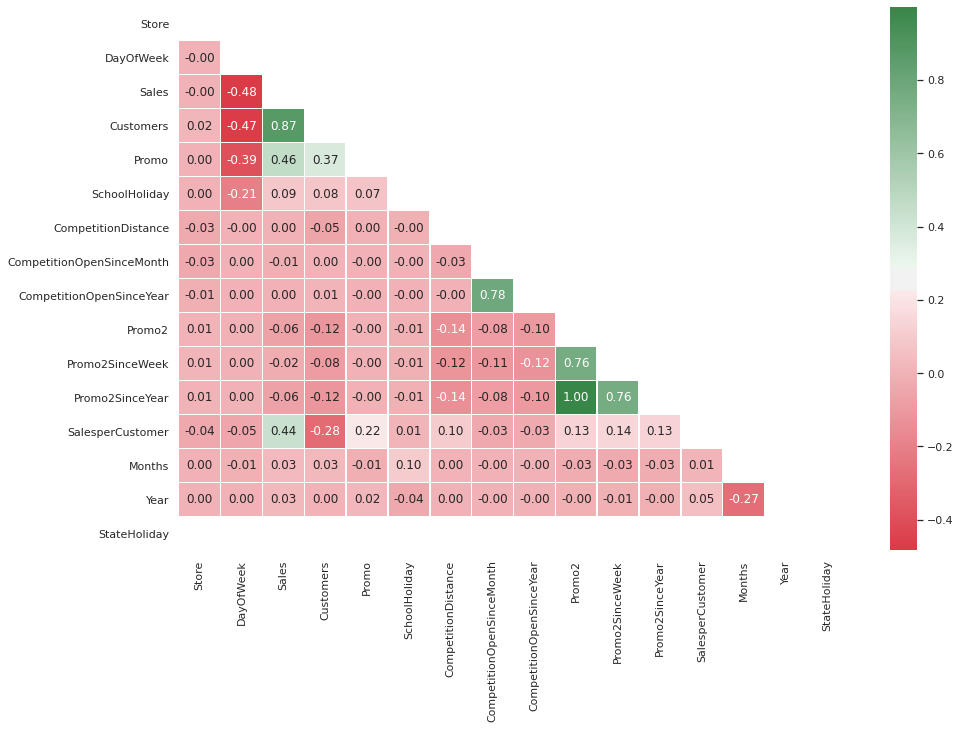

In [345]:
upper_triangle = np.zeros_like(df_correlation.corr(), dtype = np.bool)
upper_triangle[np.triu_indices_from(upper_triangle)] = True #make sure we don't show half of the other triangle
f, ax = plt.subplots(figsize = (15, 10))
sns.heatmap(df_correlation.corr(),ax=ax,mask=upper_triangle,annot=True, fmt='.2f',linewidths=0.5,cmap=sns.diverging_palette(10, 133, as_cmap=True))


-Since the competition variables CompetitionOpenSinceYear and CompeitionOpenSinceMonth have the same underlying meaning, merging them into one variable that we call CompetitionOpenSince makes easier for the algorithm to understand the pattern and creates less branches and thus complex trees.

In [346]:
train_data['CompetitionOpenSince'] = np.where((train_data['CompetitionOpenSinceMonth']==0) & 
                                                  (train_data['CompetitionOpenSinceYear']==0) , 0,
                                                  (train_data.Months - train_data.CompetitionOpenSinceMonth) 
                                                  + (12 * (train_data.Year - train_data.CompetitionOpenSinceYear)) )

In [348]:
del train_data['CompetitionOpenSinceYear']
del train_data['CompetitionOpenSinceMonth']

In [349]:
train_data.head()

,Weekdays,Weeks,Months,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Store-1,StoreType,Assortment,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,SalesperCustomer,Year,CompetitionOpenSince
0,1,23,6,867,3,5608.0,469.0,1,1,0.0,0,867,d,c,21810.0,0,0.0,0.0,"Jan,Apr,Jul,Oct",11.957356,2015,33.0
1,1,23,6,868,3,13500.0,816.0,1,1,0.0,0,868,d,c,1360.0,1,10.0,2014.0,"Jan,Apr,Jul,Oct",16.544118,2015,118.0
2,1,23,6,869,3,7007.0,932.0,1,1,0.0,0,869,c,a,230.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",7.518240,2015,164.0
3,1,23,6,870,3,7911.0,971.0,1,1,0.0,0,870,a,a,780.0,0,0.0,0.0,"Jan,Apr,Jul,Oct",8.147271,2015,74.0
4,1,23,6,871,3,9198.0,678.0,1,1,0.0,0,871,d,c,10620.0,0,0.0,0.0,"Jan,Apr,Jul,Oct",13.566372,2015,0.0


1.4 **Data Scaling and Data Encoding**

In [ ]:
train_data.dtypes

In [351]:
# create an object of the OneHotEncoder
OHE = ce.OneHotEncoder(cols=['StoreType','Assortment','PromoInterval'],use_cat_names=True)
# encode the categorical variables
train_data = OHE.fit_transform(train_data)

train_data.head()

,Weekdays,Weeks,Months,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Store-1,StoreType_d,StoreType_c,StoreType_a,StoreType_b,Assortment_c,Assortment_a,Assortment_b,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,"PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec","PromoInterval_Feb,May,Aug,Nov",SalesperCustomer,Year,CompetitionOpenSince
0,1,23,6,867,3,5608.0,469.0,1,1,0.0,0,867,1,0,0,0,1,0,0,21810.0,0,0.0,0.0,1,0,0,11.957356,2015,33.0
1,1,23,6,868,3,13500.0,816.0,1,1,0.0,0,868,1,0,0,0,1,0,0,1360.0,1,10.0,2014.0,1,0,0,16.544118,2015,118.0
2,1,23,6,869,3,7007.0,932.0,1,1,0.0,0,869,0,1,0,0,0,1,0,230.0,1,14.0,2011.0,1,0,0,7.518240,2015,164.0
3,1,23,6,870,3,7911.0,971.0,1,1,0.0,0,870,0,0,1,0,0,1,0,780.0,0,0.0,0.0,1,0,0,8.147271,2015,74.0
4,1,23,6,871,3,9198.0,678.0,1,1,0.0,0,871,1,0,0,0,1,0,0,10620.0,0,0.0,0.0,1,0,0,13.566372,2015,0.0


So far we have taken care of the missing values and the categorical (string) variables in the data. Next we will work with the continuous variables. Often the continuous variables in the data have different scales, for instance, a variable V1 can have a range from 0 to 1 while another variable can have a range from 0-1000.

Based on the type of model you are building, you will have to normalize the data in such a way that the range of all the variables is almost similar. You can do this easily in python using the StandardScaler function.
For this project we will be using Random Forest Regressor

**2. Building models with sklearn pipelines**

In [ ]:
#Defining independent and dependent variables
#let independent/Features = X
#let dependent/Target = Y
#SInce we want to predict store sales, the target/ dependent variable is sales. For features we remove all columns that are strongly correlated to sales. From correlation analysis, we see that "customers" and "salespercustomer"  have a strong positive correlation with sale. There we do away with these columns.

In [353]:
## separate the independent and target variable 
X = train_data.drop(['Customers', 'Sales', 'SalesperCustomer'], axis = 1)

In [354]:
X.head()

,Weekdays,Weeks,Months,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,Store-1,StoreType_d,StoreType_c,StoreType_a,StoreType_b,Assortment_c,Assortment_a,Assortment_b,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,"PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec","PromoInterval_Feb,May,Aug,Nov",Year,CompetitionOpenSince
0,1,23,6,867,3,1,1,0.0,0,867,1,0,0,0,1,0,0,21810.0,0,0.0,0.0,1,0,0,2015,33.0
1,1,23,6,868,3,1,1,0.0,0,868,1,0,0,0,1,0,0,1360.0,1,10.0,2014.0,1,0,0,2015,118.0
2,1,23,6,869,3,1,1,0.0,0,869,0,1,0,0,0,1,0,230.0,1,14.0,2011.0,1,0,0,2015,164.0
3,1,23,6,870,3,1,1,0.0,0,870,0,0,1,0,0,1,0,780.0,0,0.0,0.0,1,0,0,2015,74.0
4,1,23,6,871,3,1,1,0.0,0,871,1,0,0,0,1,0,0,10620.0,0,0.0,0.0,1,0,0,2015,0.0


In [355]:
#We delete store-1 because it is duplicated
del X['Store-1']

In [357]:
#a rule of thumb is to transform my target value to log if i see the values are very dispersed which is the case
#and then of course revert them with np.exp to their real values
y=np.log(train_data.Sales)
y

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


0          8.631949
1          9.510445
2          8.854665
3          8.976009
4          9.126741
             ...   
1017204    9.215626
1017205    9.099297
1017206    8.712102
1017207    9.339964
1017208    9.097955
Name: Sales, Length: 1017209, dtype: float64

In [358]:
#Splitting our dataset into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=15)
print ("Training and testing split was successful.")

Training and testing split was successful.


In [359]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Below is a funtion to help us identify if a dataframe has infinite numbers

In [361]:
def _assert_all_finite(X):
    """Like assert_all_finite, but only for ndarray."""
    X = np.asanyarray(X)
    # First try an O(n) time, O(1) space solution for the common case that
    # everything is finite; fall back to O(n) space np.isfinite to prevent
    # false positives from overflow in sum method.
    if (X.dtype.char in np.typecodes['AllFloat'] and not np.isfinite(X.sum())
            and not np.isfinite(X).all()):
        raise ValueError("Input contains NaN, infinity"
                         " or a value too large for %r." % X.dtype)

In [ ]:
_assert_all_finite(y_train) #Asserting if the y_train dataset has infinite objects, and if yes we replace them

In [364]:
#Replacing the infinite objects with nan values
y_train.replace([np.inf, -np.inf], np.nan, inplace=True) 

In [365]:
#Now we will replace the nan values with the mean
y_train.fillna(8.72337779729373, inplace=True)

**Setting up the RandomForestRegressor object**

In [366]:

regressor = RandomForestRegressor(n_estimators=10, 
                             criterion='mse',random_state=0)
regressor.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [367]:
# save the model to disk using pickle
filename = 'finalized_model.sav'
pickle.dump(regressor, open(filename, 'wb'))

In [368]:
#Predicting using the regressor model
y_pred = regressor.predict(X_test)
y_pred_l = pd.DataFrame(y_pred, columns=["sales prediction"]) #Saving the predictions into a dataframe
print(y_pred_l.head())
y_test.head()

   sales prediction
0          8.694410
1          8.723378
2          8.215211
3          8.512098
4          8.451766


991178    8.581669
4941          -inf
493413    8.271548
264865    8.488999
737476    8.558143
Name: Sales, dtype: float64

In [369]:
#Replacing the infinite values in y_test dataframe
y_test.replace([np.inf, -np.inf], np.nan, inplace=True)

In [370]:
y_test.mean() #computing the mean

8.72300394846444

In [371]:
#Replacing the nan values with the mean
y_test.fillna(8.72300394846444, inplace=True)

In [372]:
# By using loss functions we will know how our model performs

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.08720087569974283
Mean Squared Error: 0.020071843214432766
Root Mean Squared Error: 0.14167513266072054


## Feature Importance

After the preprocessing and encoding steps, we had a total of 25 features and not all of these may be useful in forecasting the sales. Alternatively we can select the top 5 or top 7 features, which had a major contribution in forecasting sales values.

If the model performance is similar in both the cases, that is – by using 25 features and by using 5-7 features, then we should use only the top 7 features, in order to keep the model more simple and efficient.

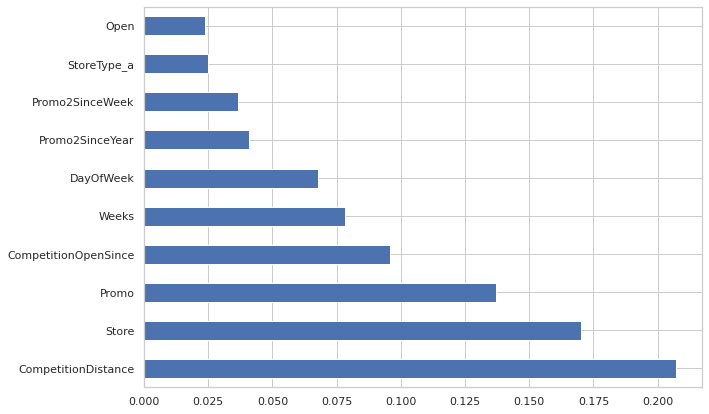

In [414]:
# plot the 7 most important features 
plt.figure(figsize=(10,7))
feat_importances = pd.Series(regressor.feature_importances_, index = X.columns)
feat_importances.nlargest(10).plot(kind='barh');

Now, we are going to train the same random forest model using these 7 features only

In [437]:
X.head()

,Weekdays,Weeks,Months,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,StoreType_d,StoreType_c,StoreType_a,StoreType_b,Assortment_c,Assortment_a,Assortment_b,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,"PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec","PromoInterval_Feb,May,Aug,Nov",Year,CompetitionOpenSince
0,1,23,6,867,3,1,1,0.0,0,1,0,0,0,1,0,0,21810.0,0,0.0,0.0,1,0,0,2015,33.0
1,1,23,6,868,3,1,1,0.0,0,1,0,0,0,1,0,0,1360.0,1,10.0,2014.0,1,0,0,2015,118.0
2,1,23,6,869,3,1,1,0.0,0,0,1,0,0,0,1,0,230.0,1,14.0,2011.0,1,0,0,2015,164.0
3,1,23,6,870,3,1,1,0.0,0,0,0,1,0,0,1,0,780.0,0,0.0,0.0,1,0,0,2015,74.0
4,1,23,6,871,3,1,1,0.0,0,1,0,0,0,1,0,0,10620.0,0,0.0,0.0,1,0,0,2015,0.0


In [438]:
X_data=X[['CompetitionDistance','Store','Promo','CompetitionOpenSince','Weeks','DayOfWeek','Promo2SinceYear','StoreType_a','Open']]

In [439]:
y_target=np.log(train_data.Sales)
y_target

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


0          8.631949
1          9.510445
2          8.854665
3          8.976009
4          9.126741
             ...   
1017204    9.215626
1017205    9.099297
1017206    8.712102
1017207    9.339964
1017208    9.097955
Name: Sales, Length: 1017209, dtype: float64

In [440]:
X_data_train, X_data_test, y_data_train, y_data_test = train_test_split(X_data, y_target, test_size=0.20, random_state=15)
print ("Training and testing split was successful.")

Training and testing split was successful.


In [441]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_data_train = sc.fit_transform(X_data_train)
X_data_test = sc.transform(X_data_test)

In [442]:
y_data_train.replace([np.inf, -np.inf], np.nan, inplace=True)

In [443]:
y_data_train.mean()

8.72337779729373

In [444]:
y_data_train.fillna(8.72337779729373, inplace=True)

In [445]:
from sklearn.ensemble import RandomForestRegressor
regressor1 = RandomForestRegressor(n_estimators=10, 
                             criterion='mse',random_state=0)
regressor1.fit(X_data_train, y_data_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [446]:
# save the new model to disk
filename = 'finalized1_model.sav'
pickle.dump(regressor1, open(filename, 'wb'))

In [447]:
#Predicting
y_pred1 = regressor1.predict(X_data_test)
y_pred_2 = pd.DataFrame(y_pred1, columns=["sales prediction"])
print(y_pred_2.head())
y_data_test.head()

   sales prediction
0          8.742488
1          8.723378
2          8.220179
3          8.502274
4          8.481200


991178    8.581669
4941          -inf
493413    8.271548
264865    8.488999
737476    8.558143
Name: Sales, dtype: float64

In [448]:
#Replacing the inf values with the nan values
y_data_test.replace([np.inf, -np.inf], np.nan, inplace=True)

In [449]:
y_data_test.mean() #Computing the mean

8.72300394846444

In [450]:
#Replacing the nan values using the mean
y_test.fillna(8.72300394846444, inplace=True)

In [ ]:
#Computing different loss functions

print('Mean Absolute Error:', metrics.mean_absolute_error(y_data_test, y_pred1))
print('Mean Squared Error:', metrics.mean_squared_error(y_data_test, y_pred1))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_data_test, y_pred1)))

## Making the Predictions

In [ ]:
test = pd.read_csv(r"/content/drive/My Drive/test.csv", parse_dates=['Date'])
store = pd.read_csv(r"/content/drive/My Drive/store.csv")


In [ ]:
test.isnull().sum()

In [ ]:
test.fillna(1, inplace = True)

In [ ]:
test['Months']=test.Date.dt.month
test['Year']=test.Date.dt.year
test['week']=test.Date.dt.week
test['weekday']=test.Date.dt.weekday

In [ ]:
test.head()

In [ ]:
#merging test and store data
test_data = pd.merge(test, store, how = 'left', on = 'Store')

In [ ]:
test_data.isnull().sum()

In [ ]:
test_data.head()

In [ ]:
#dealing with missing values
test_data['CompetitionDistance'].fillna(test_data['CompetitionDistance'].median(), inplace = True)

In [ ]:
test_data.CompetitionOpenSinceMonth.fillna(0, inplace = True)
test_data.CompetitionOpenSinceYear.fillna(0,inplace=True)

In [ ]:
test_data.Promo2SinceWeek.fillna(0,inplace=True)
test_data.Promo2SinceYear.fillna(0,inplace=True)
test_data.PromoInterval.fillna(0,inplace=True)


In [ ]:
test_data['CompetitionOpenSince'] = np.where((test_data['CompetitionOpenSinceMonth']==0) & 
                                                  (test_data['CompetitionOpenSinceYear']==0) , 0,
                                                  (test_data.Months - test_data.CompetitionOpenSinceMonth) 
                                                  + (12 * (test_data.Year - test_data.CompetitionOpenSinceYear)) )

In [ ]:
del test_data['CompetitionOpenSinceYear']
del test_data['CompetitionOpenSinceMonth']

In [ ]:
test_data.isnull().sum()

## Predicting the sales of the stores for the next six weeks 

In [ ]:
#we will use test data
test_data.head()

In [ ]:
# create an object of the OneHotEncoder
OHE = ce.OneHotEncoder(cols=['StoreType','Assortment','PromoInterval'],use_cat_names=True)
# encode the categorical variables
test_data = OHE.fit_transform(test_data)

test_data.head()

In [ ]:
del test_data['Date']

In [ ]:
test_data1=test_data.drop(['Id'],axis=1)

In [ ]:
cols = test_data1.select_dtypes(exclude=['float']).columns

test_data1[cols] = test_data1[cols].apply(pd.to_numeric, downcast='float', errors='coerce')

In [ ]:
del test_data1['PromoInterval_0']

In [ ]:
test_data1.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
test_data1.dtypes

In [ ]:
test_data1.mean()

In [ ]:
test_data1.fillna(8.72300394846444, inplace=True)

In [ ]:
sc = StandardScaler()
test_data1 = sc.fit_transform(test_data1)

In [ ]:
rossman_yhat= regressor.predict(test_data1)

rossman_preds= pd.DataFrame({'Id': test_data['Id'], 
                          'Sales': np.exp(rossman_yhat)})

In [464]:
rossman_preds.to_csv("Rossman_predictions.csv",index=False)

## Making predictions using model trained with ten features

In [452]:
test_data.head()

,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,Months,Year,week,weekday,StoreType_c,StoreType_a,StoreType_d,StoreType_b,Assortment_a,Assortment_c,Assortment_b,CompetitionDistance,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval_0,"PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Feb,May,Aug,Nov","PromoInterval_Mar,Jun,Sept,Dec",CompetitionOpenSince
0,1,1,4,1.0,1,0,0,9,2015,38,3,1,0,0,0,1,0,0,1270.0,0,0.0,0.0,1,0,0,0,84.0
1,2,3,4,1.0,1,0,0,9,2015,38,3,0,1,0,0,1,0,0,14130.0,1,14.0,2011.0,0,1,0,0,105.0
2,3,7,4,1.0,1,0,0,9,2015,38,3,0,1,0,0,0,1,0,24000.0,0,0.0,0.0,1,0,0,0,29.0
3,4,8,4,1.0,1,0,0,9,2015,38,3,0,1,0,0,1,0,0,7520.0,0,0.0,0.0,1,0,0,0,11.0
4,5,9,4,1.0,1,0,0,9,2015,38,3,0,1,0,0,0,1,0,2030.0,0,0.0,0.0,1,0,0,0,181.0


In [455]:
df_test=test_data[['Store','Promo','CompetitionDistance','CompetitionOpenSince','week','DayOfWeek','Promo2SinceYear','StoreType_a','Open']]

In [456]:
rossman1_yhat= regressor1.predict(df_test)
rossman1_preds= pd.DataFrame({'Id': test_data['Id'], 
                          'Sales': np.exp(rossman1_yhat)})

In [ ]:
rossman1_preds

In [463]:
rossman1_preds.to_csv("Rossman_prections1.csv",index=False)

# XGBoost Model Prediction

In [ ]:
predictions